In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import schedule
import time
from logger import logging
import requests
session = requests.Session()
session.verify = False

import krakenex
from pykrakenapi import KrakenAPI
api = krakenex.API()
k = KrakenAPI(api)
api.load_key('kraken_keys.py')

In [2]:
currency = 'ZUSD'
crypto = 'XETH'
pair = crypto + currency

In [138]:
df = k.get_trades_history(start=1558587601)[0]
df.index = df.index.tz_localize(tz='UTC').tz_convert('US/Central')

In [139]:
cols = ['ordertxid','cost', 'fee', 'margin', 'price', 'vol', 'type', 'ordertype']
df2 = df[cols].reset_index().groupby('ordertxid', as_index=False).agg({'dtime':'first', 'cost':'sum', 'fee':'sum', 'margin':'sum', 'price':'sum','vol':'sum', 'type':'first', 'ordertype':'first' })
df3 = df2.set_index('dtime').sort_values('dtime')
df3['is_closing'] = ['open' if x=='limit' else 'close' for x in df3['ordertype']]   

def is_long(row):
    order_type = row[0]
    is_closing = row[1]
    if ((order_type=='buy') & (is_closing=='open')) | ((order_type=='sell') & (is_closing=='close')):
        return 'long'
    else:
        return 'short'

df3['is_long'] = df3[['type', 'is_closing']].apply(is_long, axis=1)

In [140]:
df_shifted = df3.add_suffix('_buy').join(df3.shift(-1).add_suffix('_sell'))
df_trades = df_shifted[df_shifted['type_buy'] == 'buy'].copy()
df_trades['pct_return'] = (df_trades['cost_sell'] - df_trades['cost_buy'])/df_trades['cost_sell']
df_trades['abs_return'] = df_trades['cost_sell'] - df_trades['cost_buy']
df_trades['pct_return_adj'] = ((df_trades['cost_sell'] - df_trades['cost_buy']) - (df_trades['fee_buy'] + df_trades['fee_sell']))/df_trades['cost_sell']
df_trades['abs_return_adj'] = (df_trades['cost_sell'] - df_trades['cost_buy']) - (df_trades['fee_buy'] + df_trades['fee_sell'])

In [155]:
df_trades['cumsum'] = df_trades['abs_return_adj'].cumsum()+291.77
df_trades

,ordertxid_buy,cost_buy,fee_buy,margin_buy,price_buy,vol_buy,type_buy,ordertype_buy,is_closing_buy,is_long_buy,...,vol_sell,type_sell,ordertype_sell,is_closing_sell,is_long_sell,pct_return,abs_return,pct_return_adj,abs_return_adj,cumsum
dtime,,,,,,,,,,,,,,,,,,,,,
2019-05-23 08:58:20.768599987-05:00,OJWML4-BNOTT-ED32K6,1458.86603,3.50128,291.77321,240.71274,6.060610,buy,limit,open,long,...,6.060610,sell,market,close,long,-0.001271,-1.85143,-0.005874,-8.55815,283.21185
2019-05-24 15:31:34.847300053-05:00,OBC2B4-OOQQ3-ULZOVB,1416.35700,3.39926,283.27140,252.55000,5.608224,buy,limit,open,long,...,5.608224,sell,market,close,long,-0.000119,-0.16825,-0.004719,-6.68313,276.52872
2019-05-24 16:32:28.171999931-05:00,OANCYZ-RA6B3-TG6JUX,1382.94100,1.93612,276.58820,252.72000,5.472226,buy,limit,open,long,...,5.472226,sell,market,close,long,-0.006803,-9.34479,-0.010413,-14.30282,262.22590
2019-05-24 21:01:51.155900002-05:00,OQUNT3-SJ47W-7IFO2V,1311.02716,3.14647,262.20543,251.89318,5.204695,buy,limit,open,long,...,5.204695,sell,market,close,long,-0.003598,-4.70076,-0.008207,-10.72115,251.50475
2019-05-25 04:02:08.186500072-05:00,OGXRT2-DPMVY-WAA5PL,1256.92974,3.01663,251.38595,253.85000,4.951466,buy,limit,open,long,...,4.951466,sell,market,close,long,-0.009016,-11.23182,-0.013638,-16.98899,234.51576
2019-05-25 17:34:46.290999889-05:00,O3BW5U-CM2ZO-VM3CBE,1171.61950,1.64027,234.32390,252.60000,4.638240,buy,limit,open,long,...,4.638240,sell,market,close,long,-0.004214,-4.91653,-0.007820,-9.12355,225.39221
2019-05-25 20:02:58.427999973-05:00,ODHXQU-KHTJC-IN2LTF,1125.39548,2.70095,225.07910,251.94433,4.466842,buy,limit,open,long,...,4.466842,sell,market,close,long,-0.003363,-3.77149,-0.007971,-8.94001,216.45220
2019-05-26 04:03:44.968100071-05:00,OBFRC4-CG7U5-C7PXUI,1080.47390,1.51266,216.09478,250.69000,4.310000,buy,limit,open,long,...,4.310000,sell,market,close,long,-0.007955,-8.52717,-0.011566,-12.39811,204.05409
2019-05-26 09:04:01.536900043-05:00,OZNVGU-7SQOM-F6YJQL,1018.77600,1.42629,203.75520,249.70000,4.080000,buy,limit,open,long,...,4.080000,sell,market,close,long,-0.000963,-0.98000,-0.004564,-4.64544,199.40865


In [150]:
cash_on_hand = 200
cash_log = [cash_on_hand]
for x in df_trades['pct_return_adj']:
    new_cash = cash_on_hand * (1 + x)
    cash_log.append(new_cash) 
    

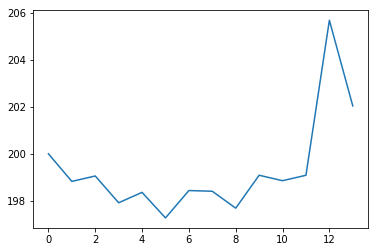

In [151]:
plt.plot(cash_log)